In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
from functools import reduce

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils

In [2]:
def multi_merge(left, right, r):
    left_cols = ["Tag"] + list(filter(r.match, left.columns))
    right_cols = ["Tag"] + list(filter(r.match, right.columns))
    return pd.merge(left[left_cols], right[right_cols], on="Tag", suffixes=(None, "_{}".format(len(left_cols)-1)))

In [3]:
def calculate_total_tag_table(dfs):
    total = reduce(lambda left, right: multi_merge(left, right, re.compile("^Count($|_)")), dfs)
    total["Count"] = total.iloc[:,1:].apply(np.sum, axis=1)
    total = total.sort_values("Count", ascending=False).reset_index(drop=True)
    total = total.loc[:, ["Tag", "Count"]]
    total["Count(%)"] = total["Count"] / total["Count"].sum() * 100
    total["Cumulative(%)"] = total["Count(%)"].cumsum()
    
    return total

In [4]:
def tag_freq(info, output, lang_to_group):
    lang_name = info["lang_name"]
    file_path = info["file_path"]
    dataset = info["dataset"]
    group = lang_to_group[lang_name]
    
    conll_data = read_conll(file_path)
    tags = np.array(conll_data[2]).flatten().sum()
    df = pd.DataFrame(list(Counter(tags).items()), columns=["Tag", "Count"])
    df = df.sort_values("Count", ascending=False).reset_index(drop=True)
    df["Count(%)"] = df["Count"] / df["Count"].sum() * 100
    df["Cumulative(%)"] = df["Count(%)"].cumsum()
    
    # Add missing tags
    tagset = pos_utils.get_ud_tags()
    missing_tags = set(tagset) ^ set(df["Tag"])
    missing_data = {col: [100]*len(missing_tags) if "Cumulative" in col else [0]*len(missing_tags) for col in df.columns[1:]}
    missing_rows = pd.DataFrame({"Tag": list(missing_tags), **missing_data},
                                index=range(df.shape[0], df.shape[0] + len(missing_tags)))
    df = pd.concat([df, missing_rows])
    
    if lang_name not in output[group].keys():
        output[group][lang_name] = {}
    output[group][lang_name][dataset] = df
    
    # Calculate totals if all datasets are done
    if len(output[group][lang_name].keys()) == 3:
        total = calculate_total_tag_table(output[group][lang_name].values())
        output[group][lang_name]["total"] = total
    
    return output

### Tag stats table

In [5]:
tag_tables = utils.run_through_data("../data/ud/", tag_freq, lang_to_group=utils.make_lang_group_dict(),
                                    table={x: {} for x in ["Fusional", "Isolating", "Agglutinative", "Introflexive"]})

In [9]:
def calculate_group_avg_tables(group_tables):
    group_avgs = {}
    
    for dataset in ["train", "dev", "test", "total"]:
        table = reduce(lambda left, right: multi_merge(left, right, re.compile("^Count\(%\)")), 
                       [group_tables[lang][dataset] for lang in group_tables.keys() if dataset in group_tables[lang].keys()])
        table = pd.DataFrame({"Tag": table["Tag"],
                              "MeanCount(%)": table.iloc[:,1:].apply(np.mean, axis=1)})
        table = table.sort_values("MeanCount(%)", ascending=False).reset_index(drop=True)
        table["Cumulative(%)"] = table["MeanCount(%)"].cumsum()
        group_avgs[dataset] = table
        
    return group_avgs

### Export excel

In [7]:
group_to_color = {
    "Fusional": "#95c78f",
    "Isolating": "#f79d97",
    "Agglutinative": "#abaff5",
    "Introflexive": "#fffecc"
}

In [16]:
for group in tag_tables.keys():
    writer = pd.ExcelWriter("tag_stats/tag_stats_{}.xlsx".format(group.lower()))
    workbook  = writer.book
    
    # Formats
    percentage_format = workbook.add_format({"num_format": "0.00\%"})
    merge_format = workbook.add_format({
        "bold": 1,
        "border": 1,
        "align": "center",
        "fg_color": group_to_color[group],
        "font_size": 14
    })
    
    # Sheet for every language
    langs = utils.order_table(pd.DataFrame(tag_tables[group].keys(), columns=["Language"])).iloc[:,0].values # Order as usual
    
    for lang in langs:
        if len(tag_tables[group][lang].keys()) > 1:
            for i, dataset in enumerate(["train", "dev", "test", "total"]):
                dcol = tag_tables[group][lang][dataset].shape[1] + 1
                tag_tables[group][lang][dataset].to_excel(writer, index=False, sheet_name=lang, 
                                                          startcol=i * dcol, startrow=1)
                worksheet = writer.sheets[lang]
                worksheet.merge_range(0, i * dcol, 0, (i + 1) * dcol - 2, dataset.upper(), merge_format)
                worksheet.set_column((i * dcol) + 2, (i * dcol) + 3, 15, percentage_format)
        else:
            i = 0
            dataset = list(tag_tables[group][lang].keys())[0]
            dcol = tag_tables[group][lang][dataset].shape[1] + 1
            tag_tables[group][lang][dataset].to_excel(writer, index=False, sheet_name=lang, startrow=1)
            worksheet = writer.sheets[lang]
            worksheet.merge_range(0, i * dcol, 0, (i + 1) * dcol - 2, dataset.upper(), merge_format)
            worksheet.set_column((i * dcol) + 2, (i * dcol) + 3, 15, percentage_format)
            
        # Insert plot
        worksheet.insert_image(tag_tables[group][lang][dataset].shape[0] + 2, 0,
                               "tag_stats/plots/langs/pos_tags_plot_{}.png".format(lang.lower()),
                               {"x_scale": 0.75, "y_scale": 0.75})
            
    # Group average sheet
    group_avgs = calculate_group_avg_tables(tag_tables[group])
    
    for i, dataset in enumerate(["train", "dev", "test", "total"]):
        dcol = group_avgs[dataset].shape[1] + 1
        group_avgs[dataset].to_excel(writer, index=False, sheet_name=group, 
                                     startcol=i * dcol, startrow=1)
        worksheet = writer.sheets[group]
        worksheet.merge_range(0, i * dcol, 0, (i + 1) * dcol - 2, dataset.upper(), merge_format)
        worksheet.set_column((i * dcol) + 1, (i * dcol) + 2, 15, percentage_format)
        
    worksheet.set_tab_color(group_to_color[group]) # Special color for group sheet
    # Insert plot
    worksheet.insert_image(group_avgs[dataset].shape[0] + 2, 0, 
                           "tag_stats/plots/groups/pos_tags_plot_{}.png".format(group.lower()),
                           {"x_scale": 0.75, "y_scale": 0.75})
            
    writer.close()

### Make plots

In [10]:
def make_plot_table(lang_tables, n, nested=True, include_total=True):
    def get_tag_order(lang_tables, n):
        tag_order = []
        for row_tags in zip(*[df.loc[:n, "Tag"] for df in lang_tables.values()]):
            for tag in np.array(Counter(row_tags).most_common(None))[:,0].tolist():
                if tag not in tag_order:
                    tag_order.append(tag)     
        return tag_order[:n]
    
    def find_freq_col(table):
        r = re.compile(".*Count\(%\)")
        return list(filter(r.match, table.columns))[0]
                    
    tag_order = get_tag_order(lang_tables, n)
    tag_order.append("OTHERS")
    plot_table = pd.DataFrame({"Tag": tag_order})
    freq_col = find_freq_col(list(lang_tables.values())[0])
    
    if nested:
        if len(lang_tables.keys()) > 1:
            datasets = include_total * ["total"] + ["test", "dev", "train"]
        else:
            datasets = lang_tables.keys()
        for dataset in datasets:
            df = lang_tables[dataset]
            selected = df.set_index("Tag").loc[tag_order[:-1]]
            plot_table[dataset.capitalize()] = [*selected[freq_col], 100 - selected[freq_col].sum()]
    else:
        langs = lang_tables.keys()
        for lang in langs:
            df = lang_tables[lang]
            selected = df.set_index("Tag").loc[tag_order[:-1]]
            freq_col = find_freq_col(df)
            plot_table[lang] = [*selected[freq_col], 100 - selected[freq_col].sum()]
    
    plot_table = plot_table.replace("_", "MULTI")
    return plot_table

In [7]:
def make_plot(table_plot, lang=None, path=None, extra_ysize=0, ax=None, xlabel=None, title=None, width=0.5, adjust_size=False, 
              use_tex=False, save=False, labels_dy=0):
    sns.set()
    sns.set_style("ticks")
    plt.rc("xtick", labelsize=16)
    plt.rc("ytick", labelsize=16)
    plt.rc("axes", labelsize=16)
    
    if adjust_size:
        figsize = (18, table_plot.shape[1] + extra_ysize)
    else:
        figsize = None
    
    g = table_plot.set_index("Tag").rename(columns={"Total": "TOTAL"}).T.plot(kind="barh", stacked=True, colormap="crest_r", 
                                                                              figsize=figsize, 
                                                                              xlim=(0, 100), ax=ax, width=width)
    for i, row in table_plot.iterrows():
        cumulative = table_plot.iloc[:i, 1:].sum().values
        current = table_plot.iloc[i, 1:].values
        for p, y in zip(row.iloc[1:], range(len(current))):
            if row[y+1] >= 1:
                x = cumulative[y] + current[y] / 2
                v_align = "center"
                rotation = None
                dx1, dy1, dx2, dy2 = (0,) * 4
                if current[y] < 3 and table_plot.iloc[i-1, y+1] < 4 and table_plot.iloc[i-1, y+1] > 0:
                    v_align = "bottom"
                    rotation = 30
                    dx1 = 1.5
                    dy1 = -0.15
                g.text(x=x+dx1, y=y+0.375+dy1+labels_dy, s=row["Tag"], fontsize=16, fontstretch="condensed", 
                       horizontalalignment="center", verticalalignment=v_align, rotation=rotation)
                if current[y] < 3:
                    dy2 = -0.375
                    dx2 = 0.2
                g.text(x=x+dx2, y=y+dy2, s="{:.1f}".format(current[y]) + use_tex*"\\" + "%", 
                       fontsize=16, fontstretch="condensed", 
                       horizontalalignment="center", verticalalignment="center",
                       bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
    g.set_xticks(range(0, 101, 10))
    if xlabel is not None:
        g.set(xlabel = xlabel)
    g.legend().remove()
    if title is not None:
        g.set_title(title, fontsize=28, pad=10, color="grey")
    sns.despine(ax=g)
    
    if save:
        g.figure.savefig(path + "pos_tags_plot_{}.png".format(lang.lower()), dpi=400)
        plt.close(g.figure)
        
    return g

In [ ]:
for group in tqdm(tag_tables.keys()):
    for lang in tag_tables[group].keys():
        table_plot = make_plot_table(tag_tables[group][lang], 5)
        make_plot(table_plot, lang, "tag_stats/plots/langs/")
        
    group_tables = calculate_group_avg_tables(tag_tables[group])
    table_plot = make_plot_table(group_tables, 5)
    make_plot(table_plot, group, "tag_stats/plots/groups/")

### Full plot

In [11]:
def retrieve_tag_data(file_path, only=None):
    def get_table(data, start, end):
        df = data[lang_name].iloc[:, start:end]
        df = df.rename(columns={col: re.sub(r"\.\d+", "", col) for col in df.columns})
        return df
    
    data = pd.read_excel(file_path, sheet_name=None, header=1)
    output = {}

    for lang_name in data.keys():
        datasets = pd.read_excel(file_path, header=0, sheet_name=lang_name).columns
        datasets = [dataset for dataset in datasets if "Unnamed" not in dataset]
    
        # Find where each stable starts and ends
        delimiters = [-1] + [data[lang_name].columns.tolist().index(col) for col in data[lang_name].columns if (
            data[lang_name][col].isnull().all()
        )] + [data[lang_name].shape[1]]

        tables = {}

        if only is None:
            for i in range(len(delimiters)-1):
                df = get_table(data, delimiters[i] + 1, delimiters[i+1])
                tables[datasets[i].lower()] = df
            output[lang_name] = tables
                
        else:
            if only.upper() in datasets:
                i = datasets.index(only.upper())
            elif only.upper() == "TOTAL" and datasets == ["TEST"]:
                # This is for you, Thai
                i = 0
            output[lang_name] = get_table(data, delimiters[i] + 1, delimiters[i+1])
        
        
    return output

In [12]:
totals = {}

for file_path in glob.glob("tag_stats/tag_stats_*.xlsx"):
    #group = re.search(r"_([a-z]+)\.", file_path).group(1).capitalize()
    totals = {**totals, **retrieve_tag_data(file_path, "total")}

In [13]:
plot_table = make_plot_table(totals, 6, nested=False).rename(columns={col: col.upper() for col in ["Fusional", 
                                                                                                   "Isolating",
                                                                                                   "Agglutinative", 
                                                                                                   "Introflexive"]})

In [14]:
sns.set()
sns.set_style("ticks")
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

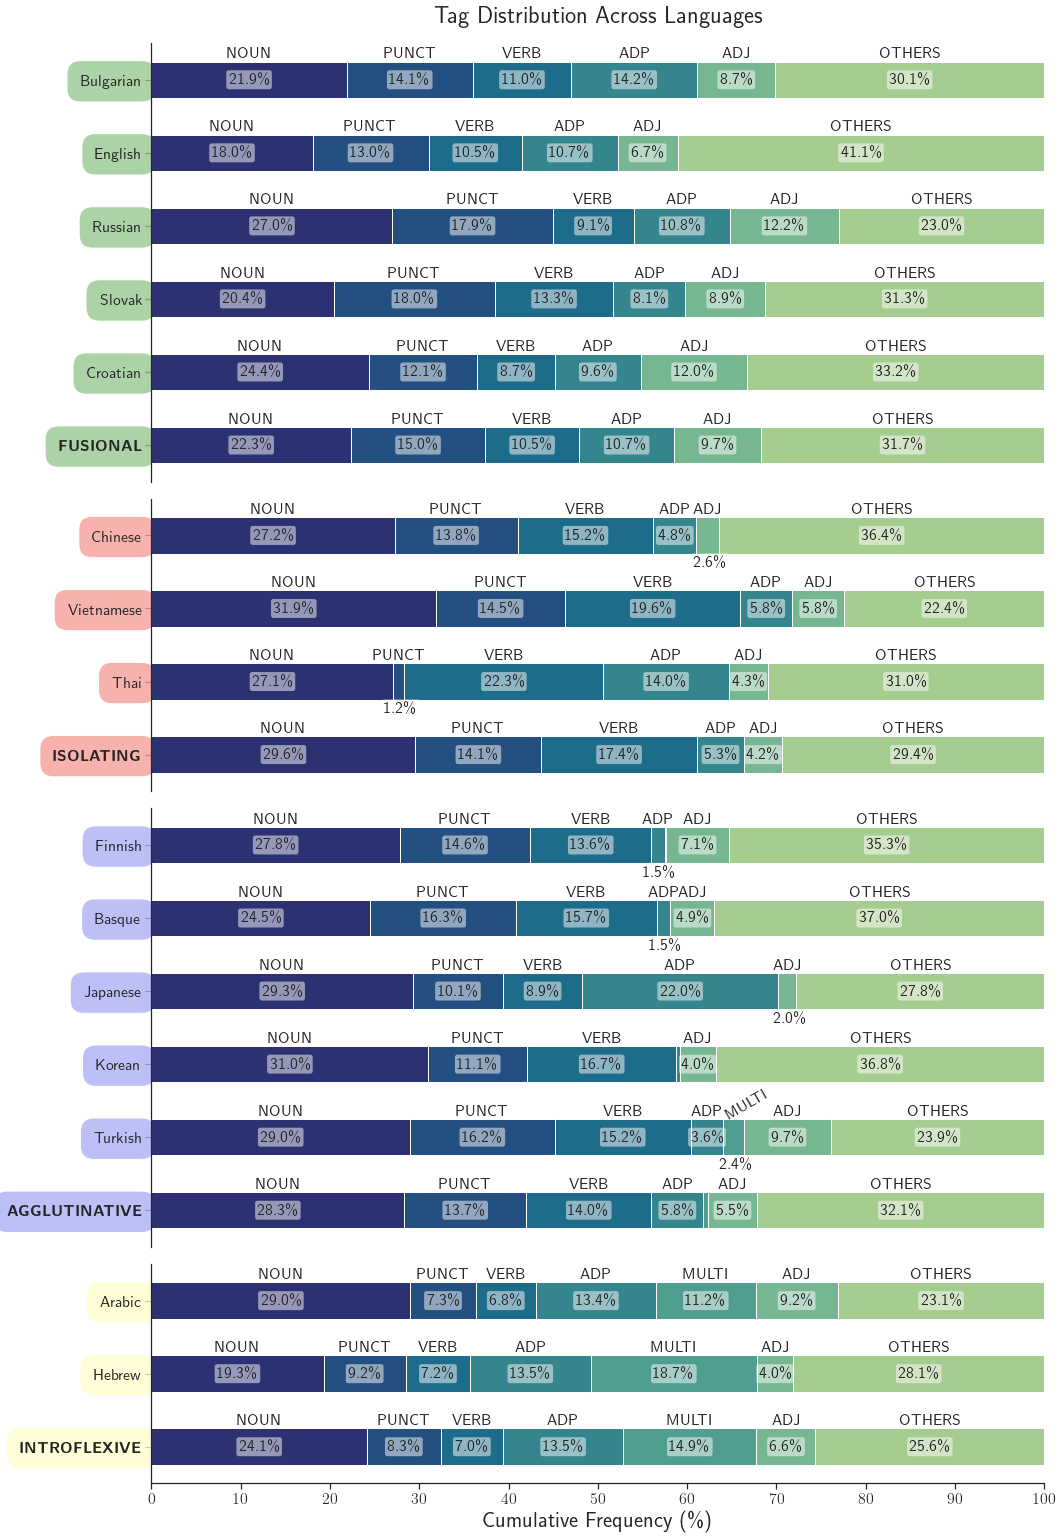

In [16]:
colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
colors = np.array([[int(hex_code[1:][i:i+2], 16) for i in (0, 2, 4)] + [200] for hex_code in colors]) / 255

f, ax = plt.subplots(4, sharex="row", gridspec_kw={'height_ratios': [6, 4, 6, 3]}, figsize=(16, 20))
plt.subplots_adjust(bottom=0, top=1, hspace=0.05)

df1 = plot_table.loc[:, ["Tag"] + ["Bulgarian", "English", "Russian", "Slovak", "Croatian", "FUSIONAL"][::-1]]
df2 = plot_table.loc[:, ["Tag"] + ["Chinese", "Vietnamese", "Thai", "ISOLATING"][::-1]]
df3 = plot_table.loc[:, ["Tag"] + ["Finnish", "Basque", "Japanese", "Korean", "Turkish", "AGGLUTINATIVE"][::-1]]
df4 = plot_table.loc[:, ["Tag"] + ["Arabic", "Hebrew", "INTROFLEXIVE"][::-1]]
dfs = [df1, df2, df3, df4]

for i, df in enumerate(dfs):
    make_plot(df, "none", "", ax=ax[i], width=0.5, use_tex=True, labels_dy=-0.02)
    if i < len(dfs) - 1:
        ax[i].set_xticks([])
    sns.despine(ax=ax[i], bottom=True)
    group_name = ax[i].yaxis.get_ticklabels()[0]
    group_name.set_text(r"\textbf{" + group_name.get_text() + "}")
    for label in ax[i].yaxis.get_ticklabels():
        label.set_bbox(dict(boxstyle="round,pad=0.85",
                                 fc=colors[i]))
    ax[i].set_yticklabels([group_name] + ax[i].yaxis.get_ticklabels()[1:])

sns.despine(ax=ax[-1])
ax[-1].set_xlabel("Cumulative Frequency (\%)", fontsize=22)
ax[0].set_title("Tag Distribution Across Languages", fontsize=24, pad=20)

#f.savefig("plots/pos_tags_full_plot.pdf", dpi=400, bbox_inches="tight")

### Distribution deviations

In [17]:
full_table = make_plot_table(totals, 18, nested=False)

In [18]:
full_table1 = full_table.loc[:, ["Tag"] + ["Bulgarian", "English", "Russian", "Slovak", "Croatian", "Fusional"][::-1]]
full_table2 = full_table.loc[:, ["Tag"] + ["Chinese", "Vietnamese", "Thai", "Isolating"][::-1]]
full_table3 = full_table.loc[:, ["Tag"] + ["Finnish", "Basque", "Japanese", "Korean", "Turkish", "Agglutinative"][::-1]]
full_table4 = full_table.loc[:, ["Tag"] + ["Arabic", "Hebrew", "Introflexive"][::-1]]
full_tables = [full_table1, full_table2, full_table3, full_table4]

In [19]:
x = []
y = []
for df in full_tables:
    x.extend([df.columns[1]] * 18)
    y.extend(df.iloc[:-1, 2:].std(axis=1))

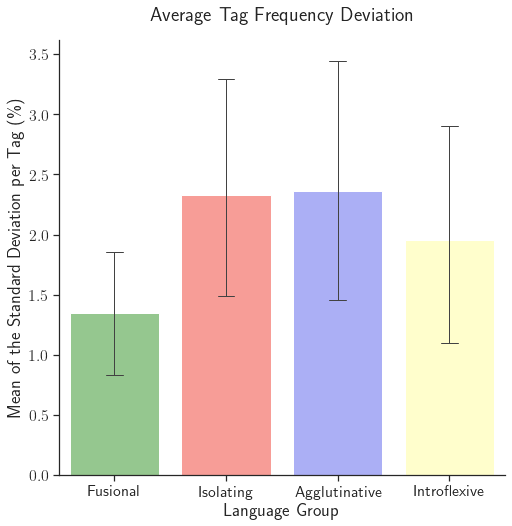

In [22]:
colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
plt.figure(figsize=(8, 8))

ax = sns.barplot(x=x, y=y, palette=colors, saturation=1, errwidth=1, capsize=0.15)
# ax.set_ylim((0, 10))
# plt.yticks(np.arange(0, 3.501, 0.5))
plt.title("Average Tag Frequency Deviation", fontsize=20, pad=20)
plt.xlabel("Language Group", fontsize=18)
plt.ylabel("Mean of the Standard Deviation per Tag (\%)", fontsize=18)
sns.despine(ax=ax)

#plt.savefig("plots/pos_tag_freq_deviation.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### Specific train/dev/test for language

In [23]:
tag_tables = utils.run_through_data("../data/ud/", tag_freq, lang_to_group=utils.make_lang_group_dict(),
                                    table={x: {} for x in ["Fusional", "Isolating", "Agglutinative", "Introflexive"]})

In [24]:
ko = make_plot_table(tag_tables["Agglutinative"]["Korean"], 5, include_total=False)

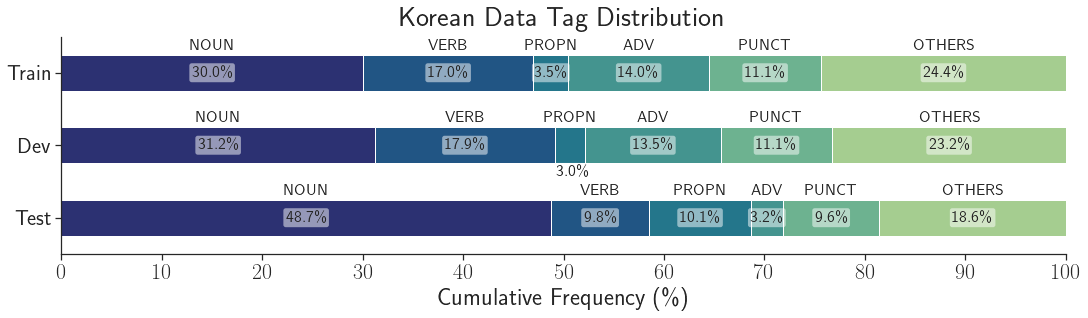

In [26]:
ax = make_plot(ko, use_tex=True, adjust_size=True)
ax.set_title("Korean Data Tag Distribution", fontsize=28, pad=10)
ax.set_xlabel("Cumulative Frequency (\%)", fontsize=24)
ax.tick_params(labelsize=22)
#ax.figure.savefig("plots/pos_tag_ko.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [27]:
tr = make_plot_table(tag_tables["Agglutinative"]["Turkish"], 5, include_total=False)

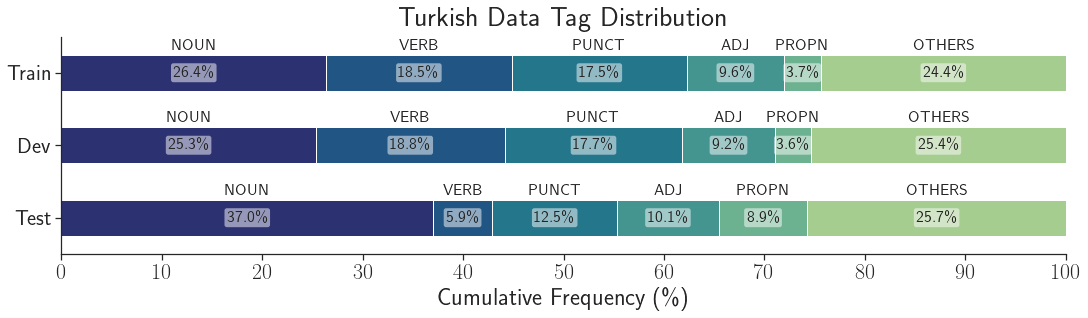

In [29]:
ax = make_plot(tr, use_tex=True, adjust_size=True)
ax.set_title("Turkish Data Tag Distribution", fontsize=28, pad=10)
ax.set_xlabel("Cumulative Frequency (\%)", fontsize=24)
ax.tick_params(labelsize=22)
#ax.figure.savefig("plots/pos_tag_tr.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()